In [73]:
!git clone https://github.com/aaravindravi/Brain-computer-interfaces.git

Cloning into 'Brain-computer-interfaces'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 130 (delta 23), reused 26 (delta 10), pack-reused 82 (from 1)
Receiving objects: 100% (130/130), 146.36 MiB | 22.21 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (21/21), done.


In [74]:
%cd Brain-computer-interfaces

/content/Brain-computer-interfaces/Brain-computer-interfaces/Brain-computer-interfaces/Brain-computer-interfaces/Brain-computer-interfaces/Brain-computer-interfaces


In [75]:
!ls

data  docs  images  notebooks  README.md  requirements.txt  scripts


# 12-Class SSVEP Dataset
## Classification Using Canonical Correaltion Analysis (CCA)
### The following is implemented on a 12-Class publicly available SSVEP EEG Dataset

<img src="../images/12_classSSVEP.png">

#### Dataset URL:
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

#### Dataset Paper:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung,
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials,"
PLoS One, vol.10, no.10, e140703, 2015.

#### Implementation:
Note: Following implementation is an asynchronous SSVEP BCI using CCA classification for 1 second data length

Aravind Ravi | eBionics Lab | University of Waterloo

In [76]:
import sys
import os
# Append the path of the 'scripts' directory to the system path.
# This assumes 'scripts' is located in 'Brain-computer-interfaces'.
sys.path.append(os.path.abspath('/content/Brain-computer-interfaces/scripts'))

# ... (rest of your import statements)


In [77]:
%%capture
import math

import numpy as np
import scipy.io as sio
from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix

from ssvep_utils import *

import matplotlib.pyplot as plt

#### Canonical Correlation Analysis (CCA)
$$\DeclareMathOperator*{\argmax}{argmax}$$

Consider two multidimensional variables $X$, $Y$ where $X$ refers to the set of multi-channel EEG data and $Y$ refers to the set of reference signals of the same length as $X$. The linear combinations of $X$ and $Y$ are given as $x = X'W_{x}$ and $y = Y'W_{y}$. CCA finds the weights, $W_{x}$ and $W_{y}$ that maximize the correlation between $x$ and $y$ by solving (1). The maximum of $\rho$ with respect to $W_{x}$ and $W_{y}$ is the maximum correlation.

$$\max_{W_{x},W_{y}} \rho(x,y) = \frac{\mathbb{E}{[W_{x}'XY'W_{y}]}}{\sqrt{\mathbb{E}{[W_{x}'XX'W_{x}]}\mathbb{E}{[W_{y}'YY'W_{y}]}}}$$

The reference signals $Y_{n}$  are defined as:

$$Y_{n} = \begin{bmatrix} \sin({2 \pi f_{n}t}) \\ \cos({2 \pi f_{n}t}) \\ \vdots \\ \sin({4 \pi  f_{n}t}) \\ \cos({4 \pi  f_{n}t}) \end{bmatrix},t = \begin{bmatrix}
    \frac{1}{f_{s}}
    \frac{2}{f_{s}}
    \dots
    \frac{N_{s}}{f_{s}}
    \end{bmatrix}$$
    
where $Y_{n} \in \mathbb{R}^{2 N_{h} \times N_{s}} $, $f_{n}$ is the stimulation frequency, $f_{s}$ is the sampling frequency, $N_{s}$ is number of samples, and $N_{h}$ is the number of harmonics. Here, $N_{h}=2$. The canonical correlation features $\rho_{f_{i}}$, where $i = 1,2,...,7$ are extracted for each segment of the EEG data, and the output class $C$ for a given sample can be determined as: $C = \argmax (\rho_{f_{i}})$



In [78]:
data_path = os.path.abspath('../Brain-computer-interfaces/data')
all_segment_data = dict()
all_acc = list()
window_len = 1
shift_len = 1
sample_rate = 256
duration = int(window_len*sample_rate)
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75,
                       10.25, 12.25, 14.25, 10.75, 12.75, 14.75])

In [79]:
def get_cca_reference_signals(data_len, target_freq, sampling_rate):
    reference_signals = []
    t = np.arange(0, (data_len/(sampling_rate)), step=1.0/(sampling_rate))
    reference_signals.append(np.sin(np.pi*2*target_freq*t))
    reference_signals.append(np.cos(np.pi*2*target_freq*t))
    reference_signals.append(np.sin(np.pi*4*target_freq*t))
    reference_signals.append(np.cos(np.pi*4*target_freq*t))
    reference_signals = np.array(reference_signals)

    return reference_signals

def find_correlation(n_components, np_buffer, freq):
    cca = CCA(n_components)
    corr = np.zeros(n_components)
    result = np.zeros(freq.shape[0])
    for freq_idx in range(0,freq.shape[0]):
        cca.fit(np_buffer.T,np.squeeze(freq[freq_idx, :, :]).T)
        O1_a,O1_b = cca.transform(np_buffer.T, np.squeeze(freq[freq_idx, :, :]).T)
        ind_val = 0
        for ind_val in range(0,n_components):
            corr[ind_val] = np.corrcoef(O1_a[: ,ind_val], O1_b[:, ind_val])[0 ,1]
            result[freq_idx] = np.max(corr)

    return result

def cca_classify(segmented_data, reference_templates):
    predicted_class = []
    labels = []
    for target in range(0, segmented_data.shape[0]):
        for trial in range(0, segmented_data.shape[2]):
            for segment in range(0, segmented_data.shape[3]):
                labels.append(target)
                result = find_correlation(1, segmented_data[target, :, trial, segment, :],
                                      reference_templates)
                predicted_class.append(np.argmax(result)+1)
    labels = np.array(labels)+1
    predicted_class = np.array(predicted_class)

    return labels, predicted_class

# Load dataset, filter and segment epochs

In [80]:
for subject in np.arange(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')

    num_classes = eeg.shape[0]
    n_ch = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]

    filtered_data = get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segment_data[f's{subject+1}'] = get_segmented_epochs(filtered_data, window_len,
                                                           shift_len, sample_rate)

# Generating the required sinusoidal templates for the given 12-class SSVEP classification

In [81]:
reference_templates = []
for fr in range(0, len(flicker_freq)):
    reference_templates.append(get_cca_reference_signals(duration, flicker_freq[fr], sample_rate))
reference_templates = np.array(reference_templates, dtype='float32')

# Perform CCA on the segmented epochs

In [82]:
for subject in all_segment_data.keys():
    labels, predicted_class = cca_classify(all_segment_data[subject], reference_templates)
    c_mat = confusion_matrix(labels, predicted_class)
    accuracy = np.divide(np.trace(c_mat), np.sum(np.sum(c_mat)))
    all_acc.append(accuracy)
    print(f'đối tượng: {subject}, Độ chính xác: {(accuracy)*100} %')

đối tượng: s1, Độ chính xác: 29.166666666666668 %
đối tượng: s2, Độ chính xác: 26.25 %
đối tượng: s3, Độ chính xác: 59.44444444444444 %
đối tượng: s4, Độ chính xác: 80.27777777777779 %
đối tượng: s5, Độ chính xác: 52.361111111111114 %
đối tượng: s6, Độ chính xác: 87.22222222222223 %
đối tượng: s7, Độ chính xác: 69.16666666666667 %
đối tượng: s8, Độ chính xác: 96.66666666666667 %
đối tượng: s9, Độ chính xác: 66.38888888888889 %
đối tượng: s10, Độ chính xác: 65.27777777777779 %


In [83]:
all_acc = np.array(all_acc)
print(f'Độ chính xác trung bình: {np.mean(all_acc)*100} %, std: {np.std(all_acc)*100} %')

Độ chính xác trung bình: 63.22222222222222 %, std: 21.665580457103147 %


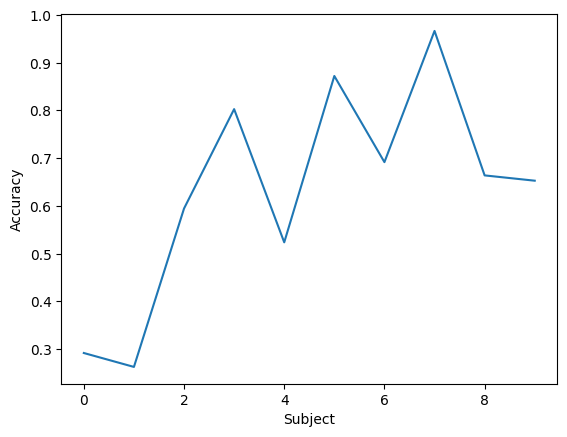

In [84]:
plt.plot(all_acc)
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()